In [ ]:
!pip install cohere

In [ ]:
import os
import pandas as pd
import re
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import time
from cohere.custom_model_dataset import CsvDataset, InMemoryDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
api_key = 'YOUR_COHEREAI_API_KEY_HERE'
co = cohere.Client(api_key)

## Prepare the data

a. import it

b. replace the 0s and 1s with clickbait and not clickbait

c. convert the dataset into a json of prompt-completion pairs

d. split in into training and validation pairs

In [ ]:
clickbait_df=pd.read_csv("clickbait_data.csv")
clickbait_df.dropna(how="any", inplace=True)

In [ ]:
clickbait_df=clickbait_df.rename(columns={'headline':'Prompt','clickbait':'Completion'})

In [ ]:
# Replace multiple values in column 'B'
clickbait_df['Completion'].replace({1: ' clickbait\n', 0: ' not clickbait\n'}, inplace=True)

In [ ]:
clickbait_df['Prompt']=clickbait_df['Prompt']+'/n is the above statement a clickbait or not?\n\n###\n\n'

In [ ]:
def get_dec_percent(x, dec, exclude=None):
    if exclude is not None:
        x = x[~x.index.isin(exclude.index)]
    return x.sample(frac=dec)

df_train = clickbait_df.groupby('Completion').apply(get_dec_percent, 0.05)
df_validation = clickbait_df.groupby('Completion').apply(get_dec_percent, 0.50, exclude=df_train)


In [ ]:
df_test = clickbait_df.groupby('Completion').apply(get_dec_percent, 0.01, exclude=pd.concat([df_train, df_validation]))

In [ ]:
df_validation['Completion'].value_counts()

In [ ]:
df_train.to_json("prompt_completions_prepared_train.jsonl", orient='records', lines=True)
df_validation.to_json("prompt_completions_prepared_valid.jsonl", orient='records', lines=True)

In [ ]:
df_validation.reset_index(drop=True, inplace=True)
df_train.reset_index(drop=True, inplace=True)

In [ ]:
df_train.to_csv("finetuning_data.csv")
df_validation.to_csv("finetuning_data_for_evaluation.csv")

In [ ]:
data_list = [tuple(row) for row in df_train.values]

In [ ]:
eval_data_list = [tuple(row) for row in df_validation.values]

## Fine-tune the model


In [ ]:
dataset = InMemoryDataset(training_data = data_list)
finetune = co.create_custom_model("prompt-completion-ft-1", dataset=dataset, model_type="GENERATIVE")

In [ ]:
dataset_with_eval = InMemoryDataset(training_data = data_list, eval_data=eval_data_list)
finetune_with_eval_ = co.create_custom_model("prompt-completion-ft-with-eval", dataset=dataset_with_eval, model_type="GENERATIVE")

In [ ]:
finetune_with_eval_

'QUEUED'

In [ ]:
response = co.generate(
      model="model_id",
      prompt="florida man is dead, clickbait or not? \n\n###\n\n",
      stop_sequences=["\n\n###\n\n"],
      return_likelihoods='NONE')

In [ ]:
# model = co.get_model()

predicted_labels = []
actual_labels = []

# Load your evaluation dataset
test_list=df_test.to_dict('records')
i=0
# Generate text using the fine-tuned model
for item in test_list:
    response = co.generate(
      model="cb8fa9d1-1a97-4825-b683-ef6694f6243f-ft",
      prompt=item['Prompt'],
      stop_sequences=["\n\n###\n\n"],
      return_likelihoods='NONE')

    generated_completion = response.generations[0].text

    # Assuming 'completion' column contains the expected completion in the test dataset
    expected_completion = item['Completion']

    predicted_labels.append(generated_completion)
    actual_labels.append(expected_completion)
    i=i+1
    print(i)
    time.sleep(25)



The above loop can take a long time to finish, because the free trial cohere api key only allows 5 calls per minute, thus why there's a timer line in the code. So, it's better to pickle the 'actual_labels' and 'predicted_labels' list, so they can be used again.

In [ ]:
# Saving the list to a file
with open('actual_labels.pickle', 'wb') as file:
    pickle.dump(actual_labels, file)

In [ ]:
# Saving the list to a file
with open('predicted_labels.pickle', 'wb') as file:
    pickle.dump(predicted_labels, file)

In [ ]:
# Open the pickle file in binary mode
with open('predicted_labels.pickle', 'rb') as f:
    # Load the contents of the pickle file
     predicted_labels = pickle.load(f)

# The variable 'data' now contains the contents of the pickle file as a list


In [ ]:
# Open the pickle file in binary mode
with open('actual_labels.pickle', 'rb') as f:
    # Load the contents of the pickle file
     actual_labels = pickle.load(f)


In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score(actual_labels, predicted_labels)
precision = precision_score(actual_labels, predicted_labels, average='weighted')
recall = recall_score(actual_labels, predicted_labels, average='weighted')
f1 = f1_score(actual_labels, predicted_labels, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.99375
Precision: 0.99375
Recall: 0.99375
F1-score: 0.99375


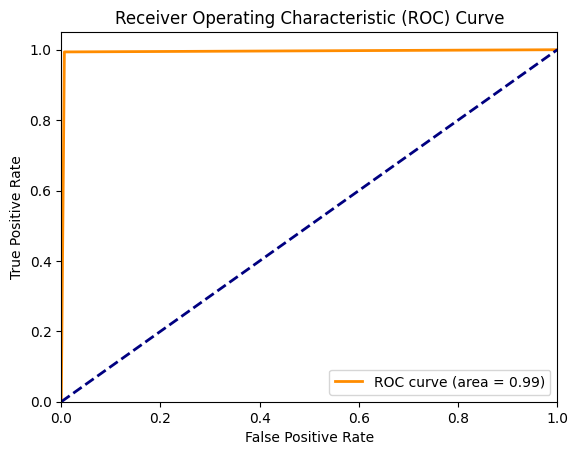

In [ ]:
predicted_labels_numeric = [1 if label == ' clickbait\n' else 0 for label in predicted_labels]

# Convert the actual labels to numerical format
actual_labels_numeric = [1 if label == ' clickbait\n' else 0 for label in actual_labels]

# Compute the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(actual_labels_numeric, predicted_labels_numeric)

# Compute the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()